In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import multivariate_normal
import seaborn as sns
import random

In [2]:
data = pd.read_csv('accData.csv')
data = data[data.columns[1:]]
len(data)

95154

In [3]:
outcomeCount = data.groupby(by = 'Outcome').count().reset_index()

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

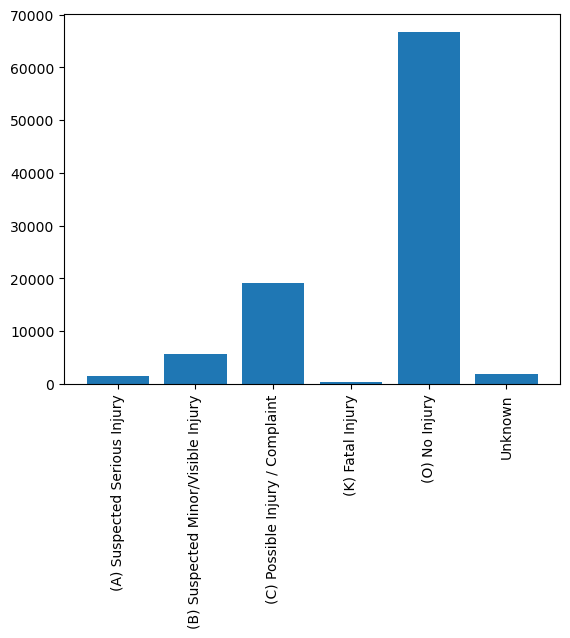

In [4]:
plt.bar(outcomeCount['Outcome'], outcomeCount['Weather'])
plt.xticks(rotation=90)

In [5]:
## Remove outliers based on longitude and lattitude
filtered = data.loc[(data['lat'] < -84) & (data['lat'] > -84.9) & (data['lng'] < 34.5) & (data['lng'] >33.3)].copy()
filtered

,Outcome,Weather,Surface,Light,lat,lng,Season,TODBucket,DOW,DLS,Holiday
0,(O) No Injury,Rain,Wet,Dark-Lighted,-84.36166,33.81943,Fall,Night,6,0,0
1,(O) No Injury,Rain,Wet,Dark-Lighted,-84.34311,34.03851,Fall,RH,0,0,0
2,(O) No Injury,Clear,Dry,Daylight,-84.57278,33.72991,Fall,Day,2,0,0
3,(O) No Injury,Cloudy,Wet,Dark-Not Lighted,-84.40855,33.66848,Fall,Night,1,0,0
4,(O) No Injury,Clear,Dry,Dark-Lighted,-84.35708,33.82307,Fall,Night,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
95149,(C) Possible Injury / Complaint,Rain,Wet,Daylight,-84.26860,34.07476,Winter,RH,3,0,0
95150,(O) No Injury,Cloudy,Dry,Daylight,-84.44356,33.67036,Winter,Day,6,0,0
95151,(O) No Injury,Clear,Dry,Dark-Lighted,-84.39034,33.76468,Winter,Night,5,0,0
95152,(B) Suspected Minor/Visible Injury,Clear,Dry,Daylight,-84.40163,33.73702,Summer,RH,0,0,0


In [6]:
##Standardize longitude and latitude
meanlat = np.mean(filtered['lat'])
Slat = np.std(filtered['lat'])

meanlong = np.mean(filtered['lng'])
Slong = np.std(filtered['lng'])

filtered['lat'] = (filtered['lat'] - meanlat)/Slat
filtered['lng'] = (filtered['lng'] - meanlong)/Slong


In [7]:
# filterData = data.loc[(data['lat'] < 2) & (data['lat'] > -2) & (data['lng'] < 2) & (data['lng'] >-2)]
MLEdata = np.array(filtered[['lat', 'lng']]).copy()

In [8]:
# nGroups = 5
# nObs = len(MLEdata[:,0])

# I = np.eye(2)

# length = 50

# loss = np.zeros(length)

# for i in range(nGroups):
#     vars()['mean'+str(i)] = np.random.normal(0, 1, size=2)
    
#     vars()['S'+str(i)] = np.random.normal(0, 1, size=(2, 2))
    
#     vars()['cov'+str(i)] = vars()['S'+str(i)] @ vars()['S'+str(i)] + I

#     vars()['pi'+str(i)] = 1/nGroups
    

    

In [72]:
def initialize(number):
    ## Create arrays
    means = np.zeros((number,2))
    S = np.zeros((number,2,2))
    cov = np.zeros((number,2,2))
    pi = np.ones(number)/number
    mu = np.zeros((number,2,2))
    count = np.zeros(number)
    
    ## Set random values
    for y in range(number):
        means[y] = np.random.normal(0, 2, size=2)
        S[y] = np.random.normal(0, 1, size=(2, 2))
        cov[y] = S[y] @ S[y].T + np.eye(2)
    
    return means, S, cov, pi, mu, count


def update_P(data, meanMatrix, covMatrix):
    ## Find dimensions of data
    length = len(meanMatrix) ##Number of clusters
    nObs = len(data)

    ## Create probability array
    p = np.zeros((nObs, length))
    
    ## Loop through all clusers
    for y in range(length): 
        ## Calculate probabilities
        p[:,y] = multivariate_normal.pdf(data, mean = meanMatrix[y], cov = covMatrix[y])
        
    return p 

In [73]:
np.random.seed(1)

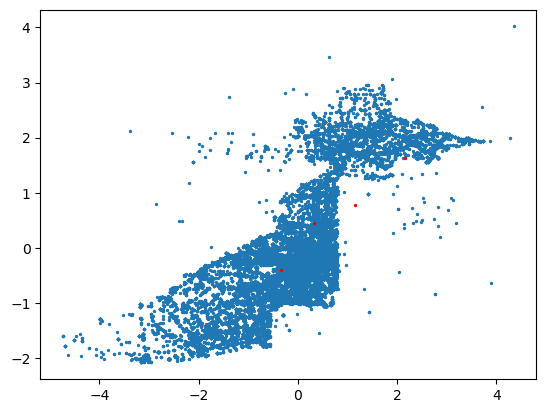

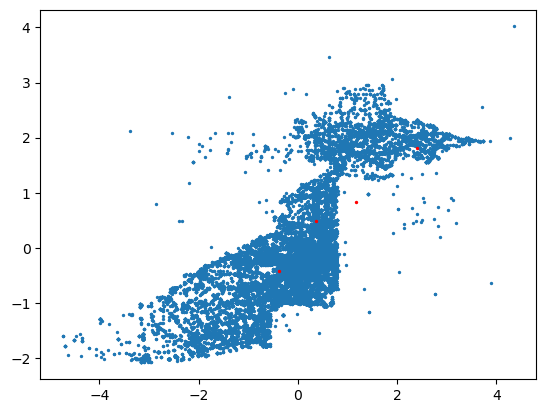

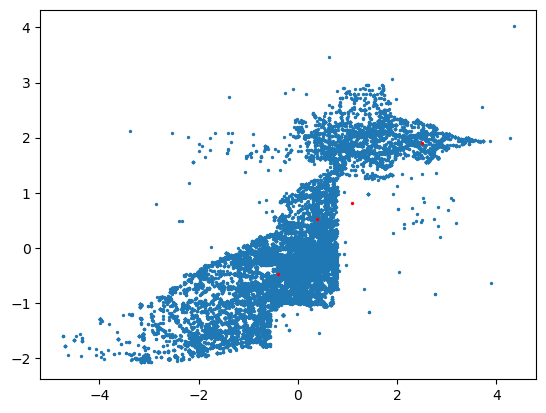

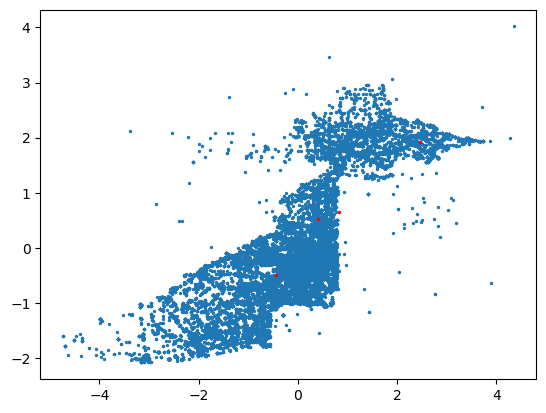

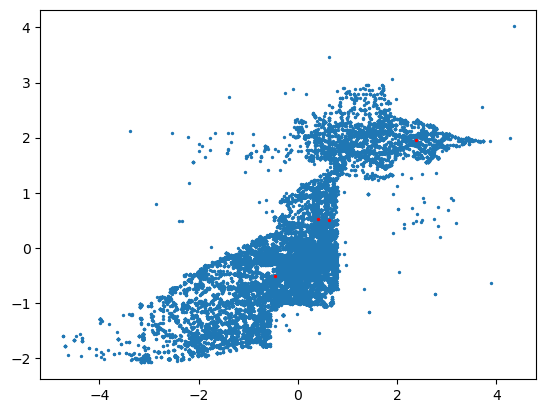

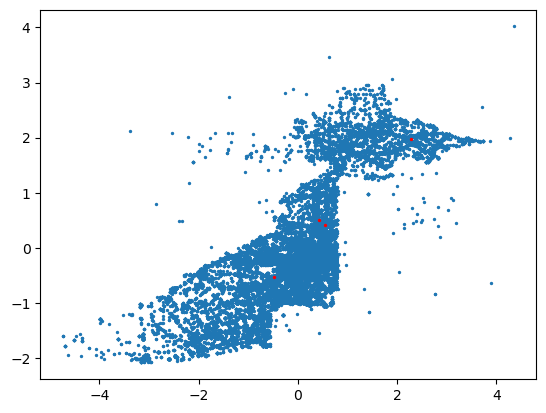

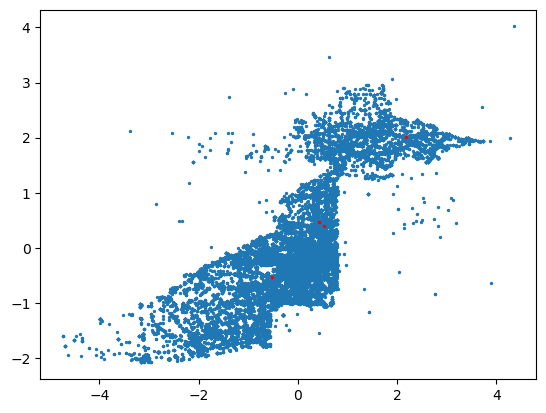

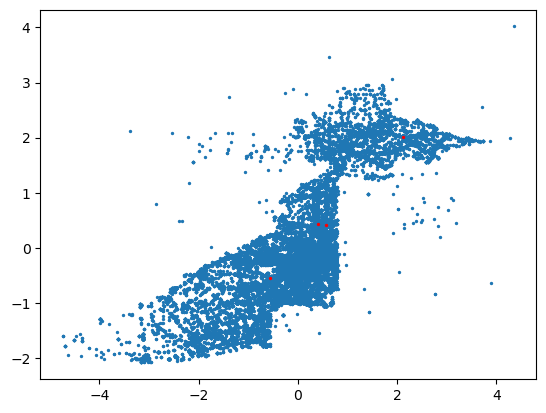

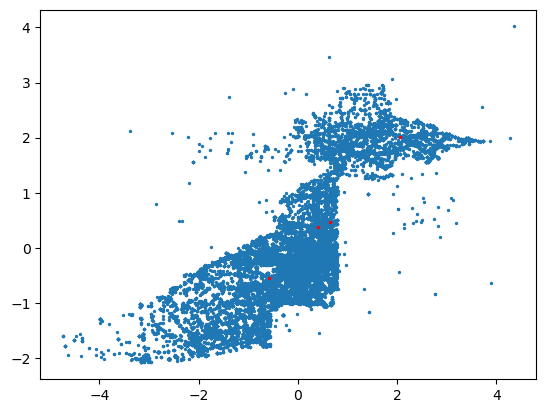

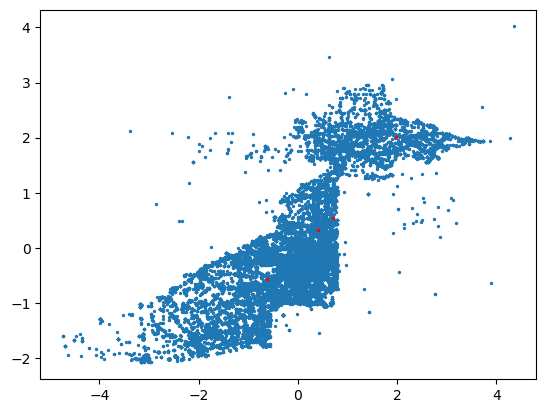

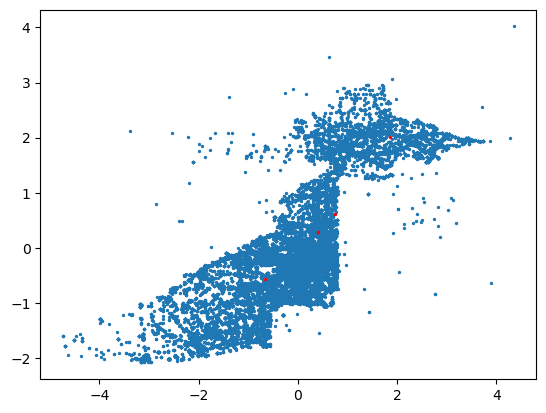

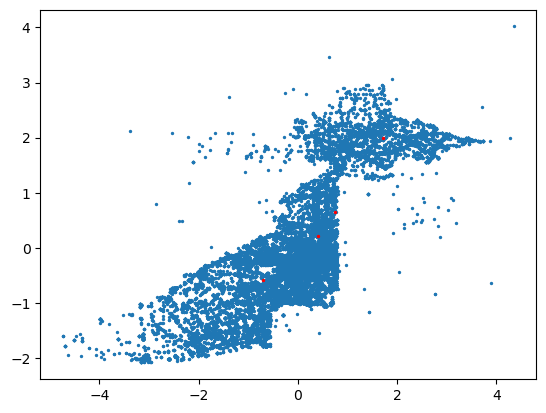

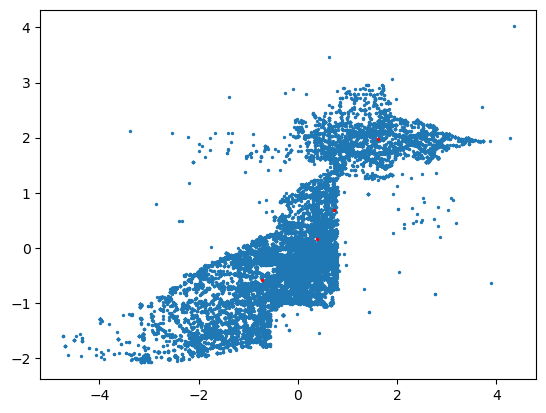

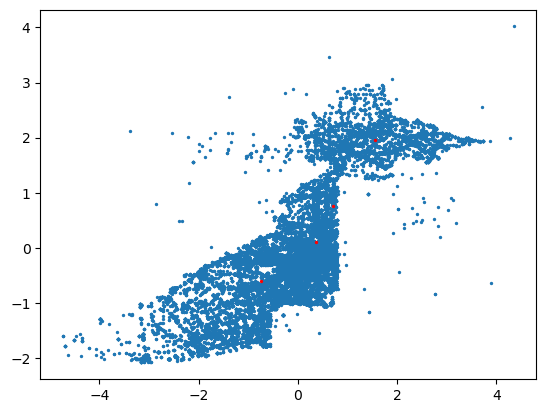

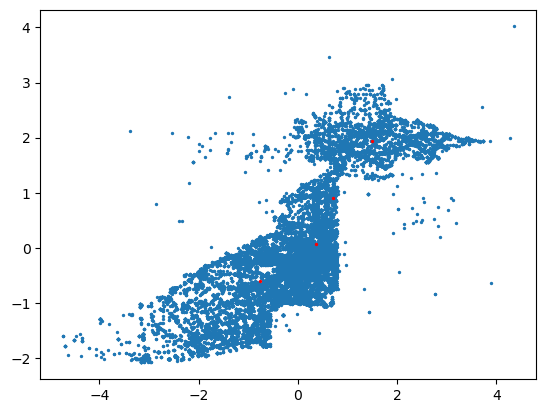

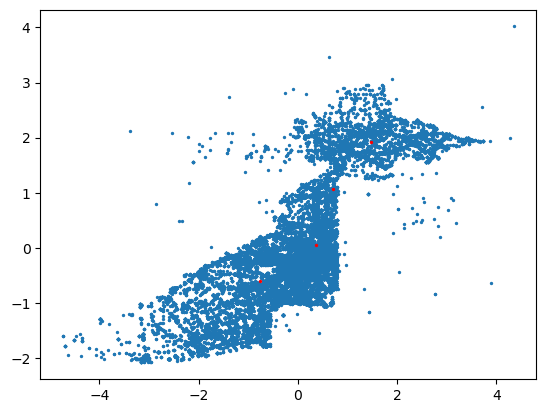

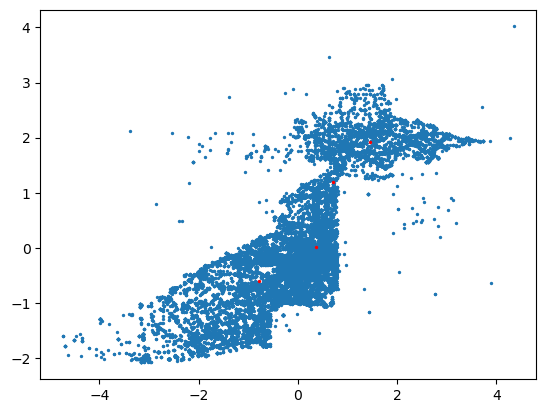

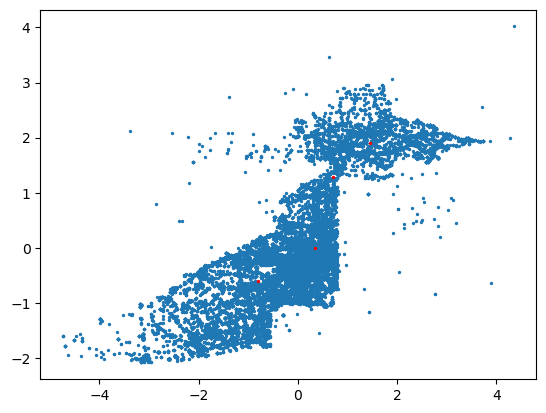

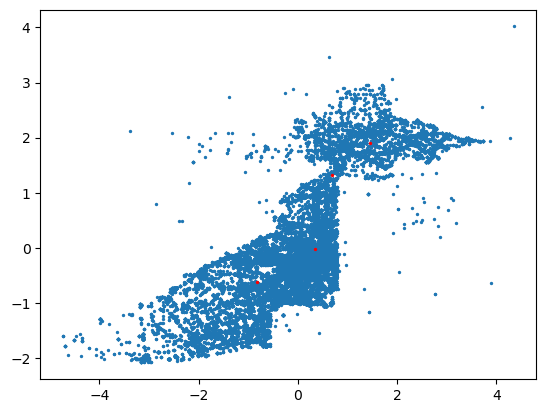

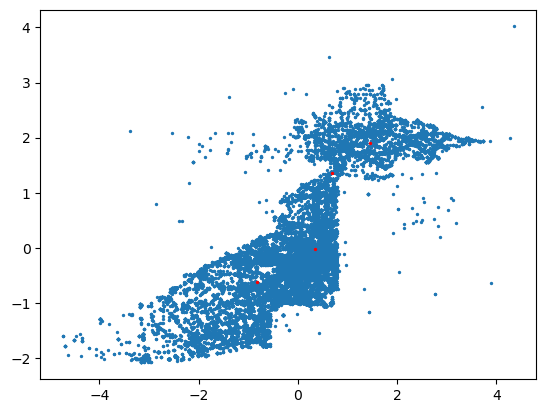

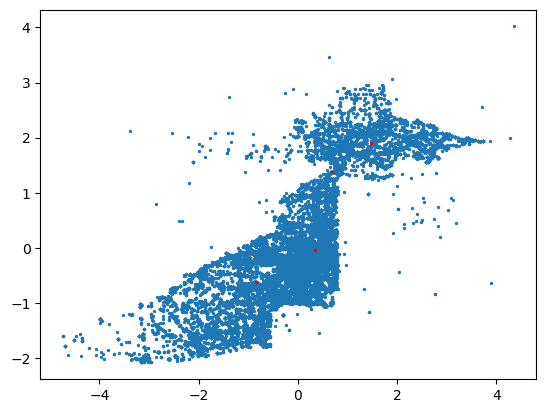

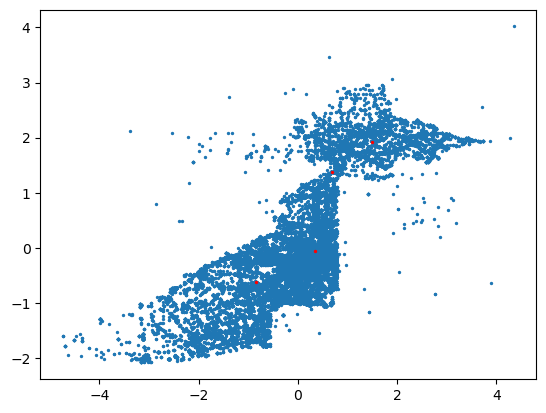

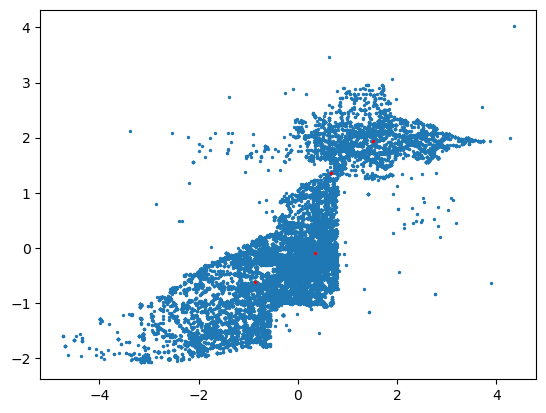

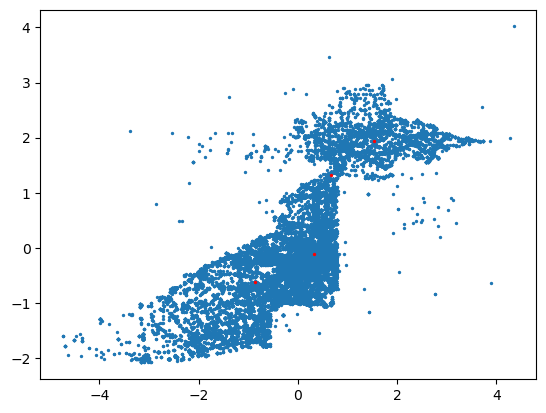

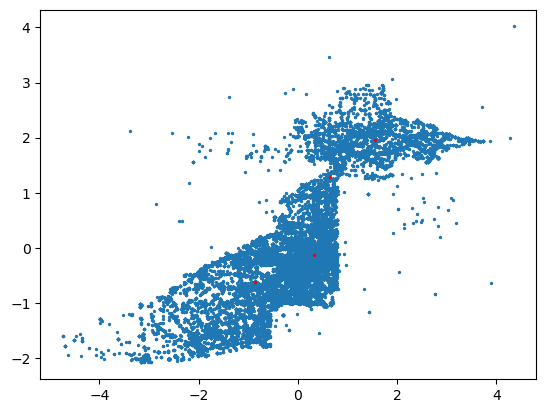

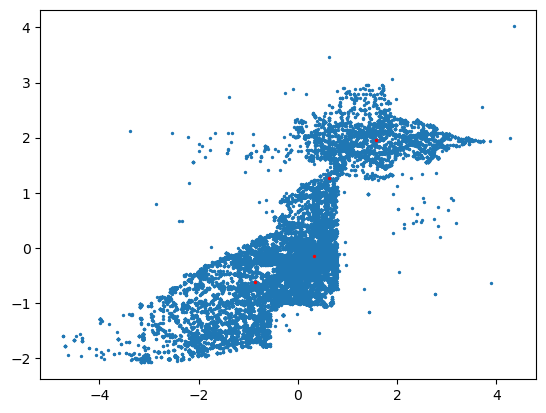

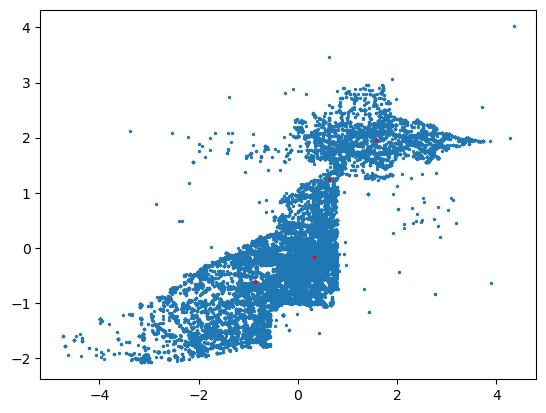

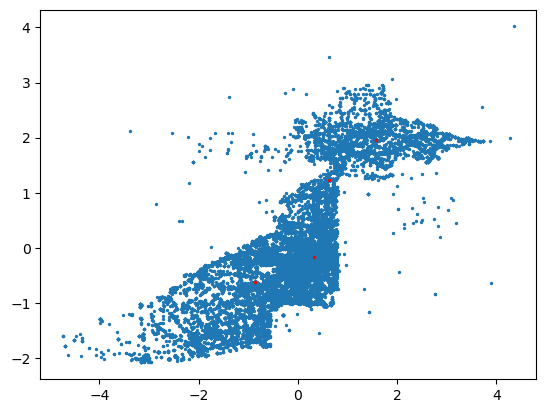

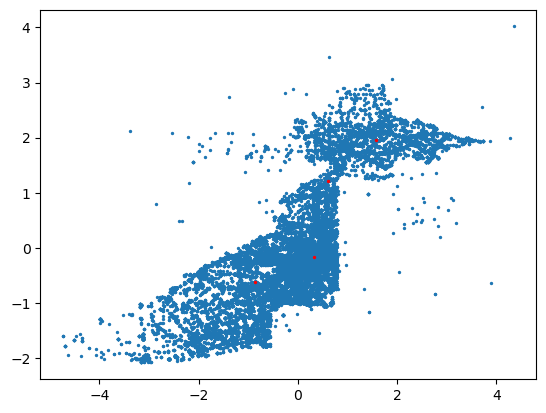

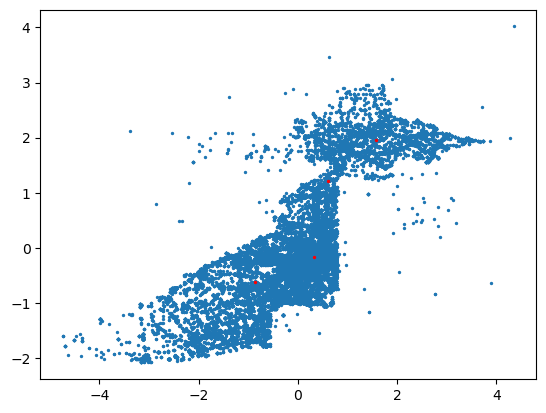

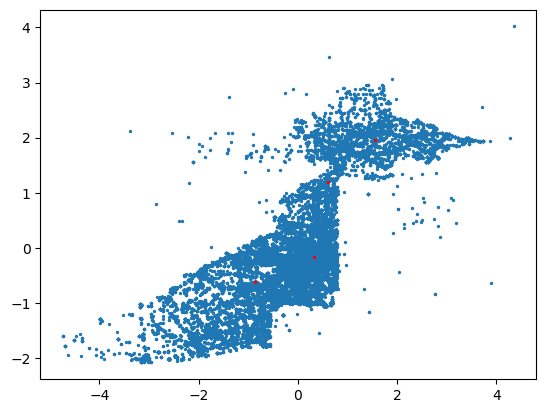

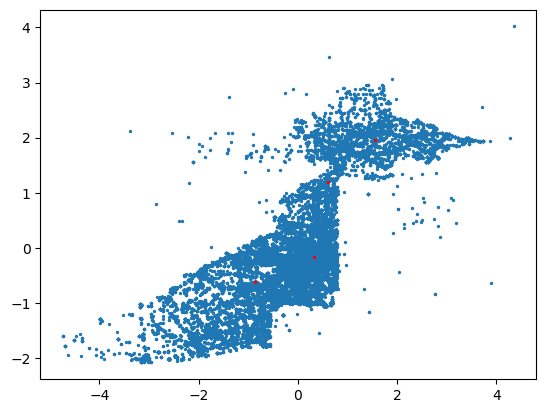

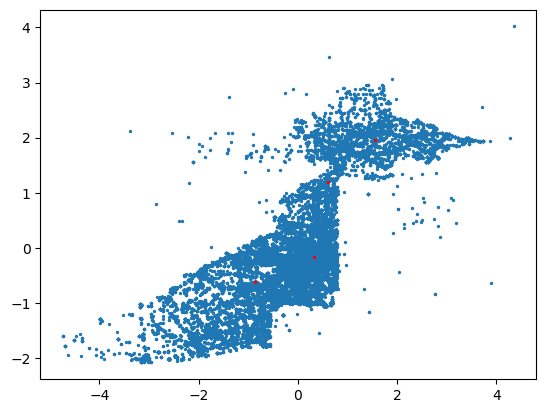

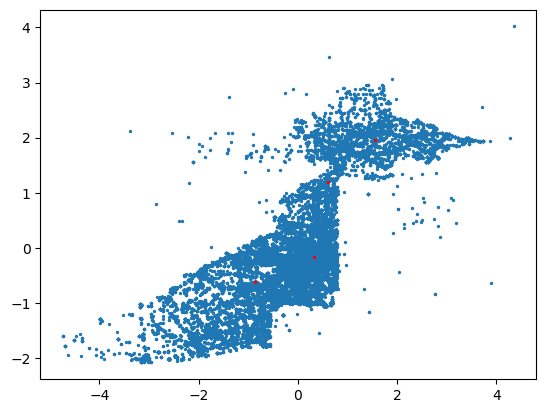

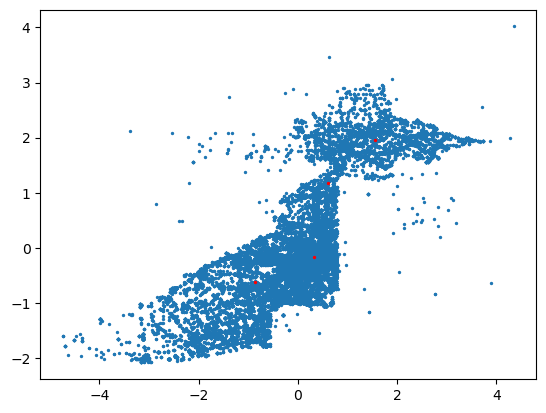

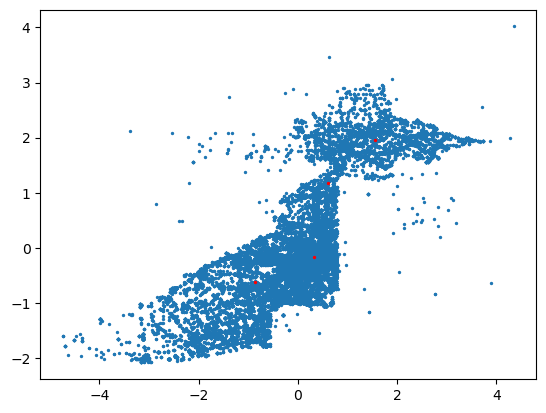

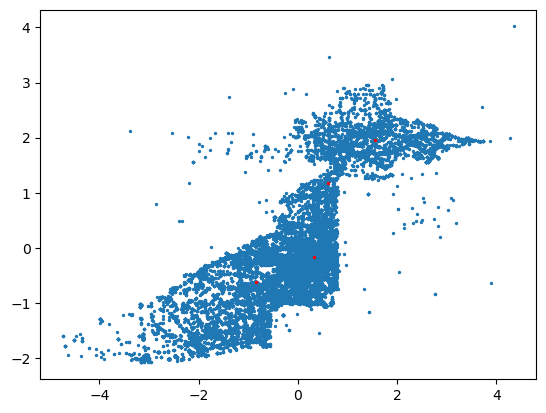

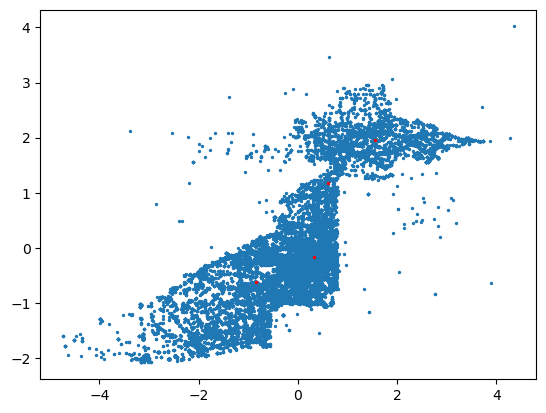

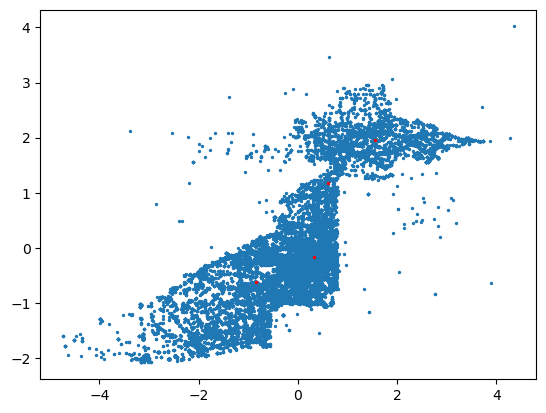

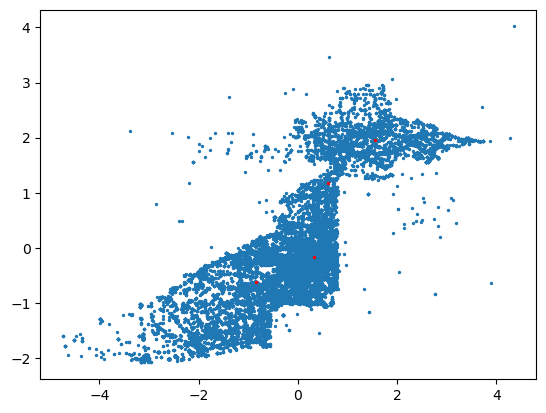

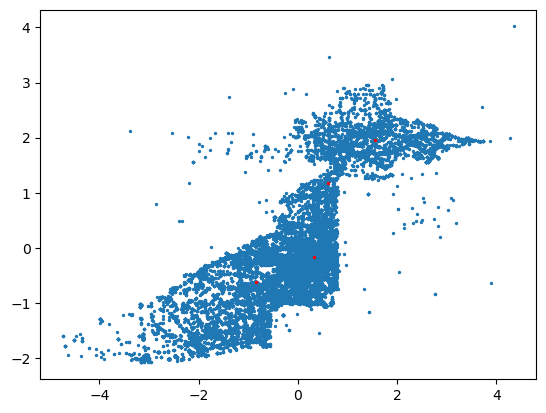

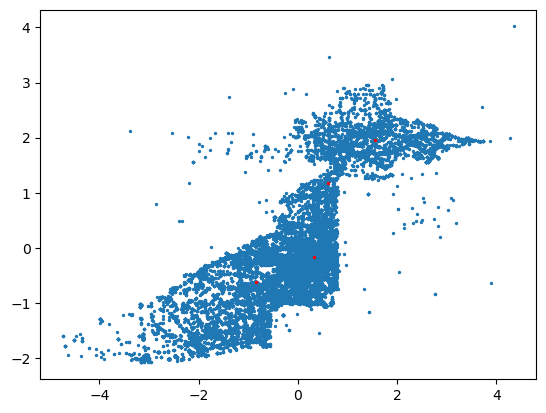

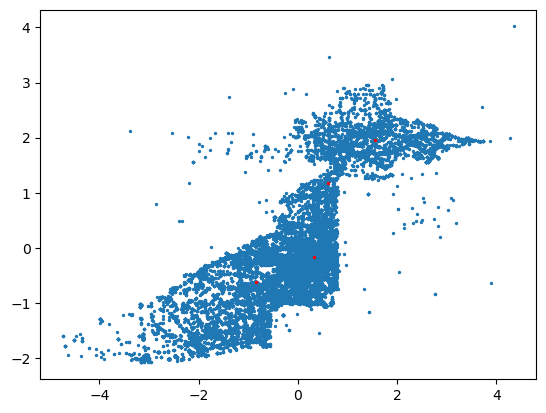

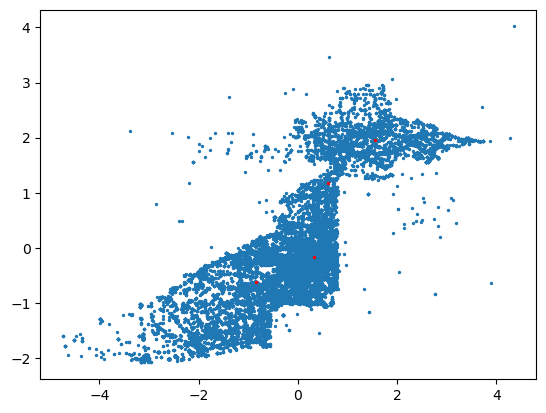

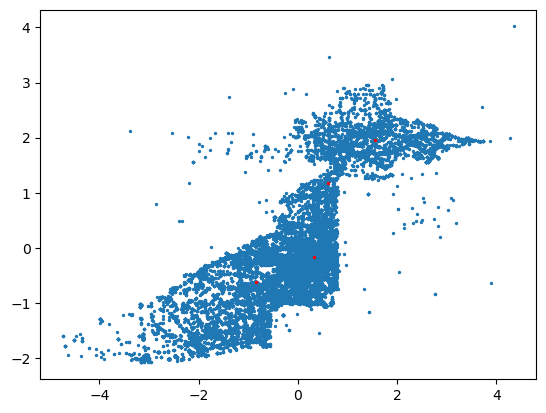

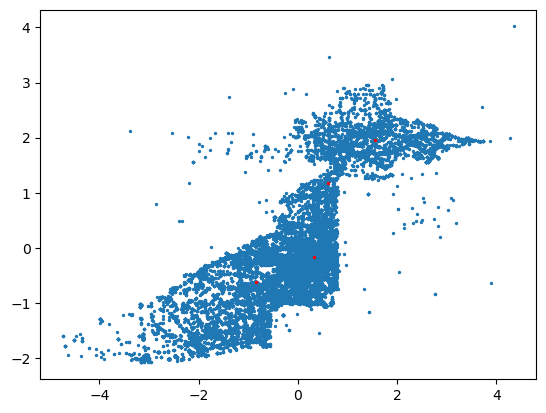

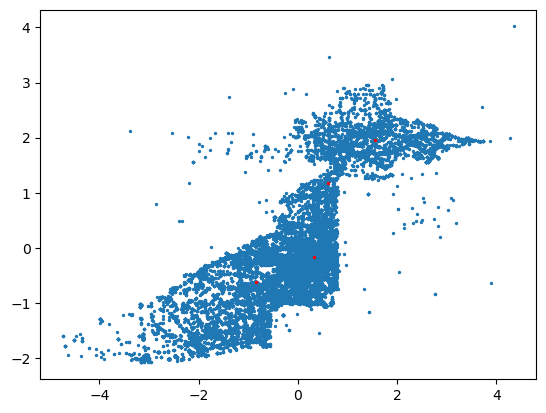

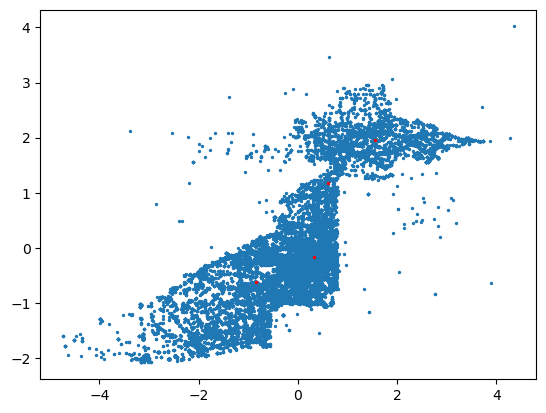

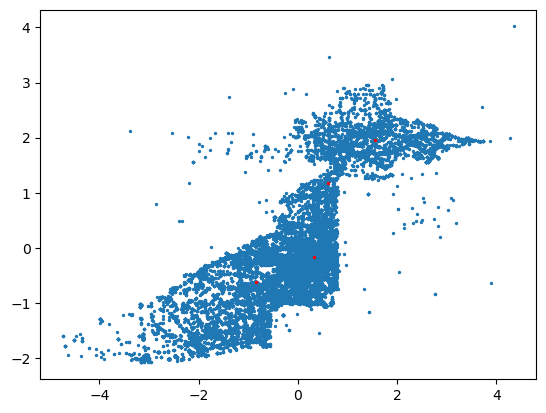

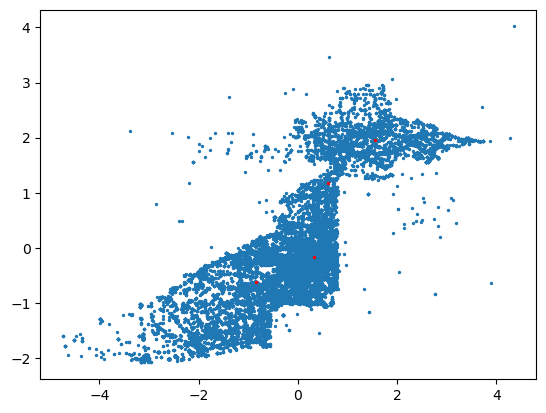

In [74]:
## Pre-specify the number of clusters
nGroups = 4

## Initialize values
means, S, cov, pi, mu, count = initialize(nGroups)

iters = 50
nObs = len(MLEdata[:,0])

I = np.eye(2)

loss = np.zeros(iters)

## Initial probabilities (Expectation)
p = update_P(MLEdata, means, cov)


##Start Iters here
for x in range(iters):

    ## Expectation step
    p = p*pi
    
    sumP = np.sum(p, axis = 1)

    Q = (p.T / sumP).T

    sums = np.sum(Q,axis = 0)

    ## Maximixation step
    mu = (np.dot(Q.T, MLEdata).T)/sums
    diff = np.zeros((nGroups,nObs,2))
    
    for y in range(nGroups):
        diff[y] = MLEdata - mu.T[y]
        cov[y] = diff[y].T.dot(diff[y]*Q[:,y][...,np.newaxis]) / sums[y]  #####REMOVED Identity

    pi = sums / nObs
    
    ## New expectations for next iteration
    p = update_P(MLEdata, mu.T, cov) ######Changed means to mu.T
    
    ## Calculate Loss
    lossTemp = 0
    for y in range(nGroups):
        lossTemp += np.sum(np.multiply(Q[:,y], np.log(pi[y]) + np.log(p[:,y]) ))
    
    ## Store loss 
    loss[x] = lossTemp
    
    ## Plot new clusters atop all observations
    xmu = []
    ymu = []
    for i in range(nGroups):
        xmu.append(mu.T[i][0])
        ymu.append(mu.T[i][1])
    
    plt.scatter(MLEdata[:,0], MLEdata[:,1], s = 2)
    plt.scatter(xmu,ymu, color = 'red', s = 2)
    plt.show()


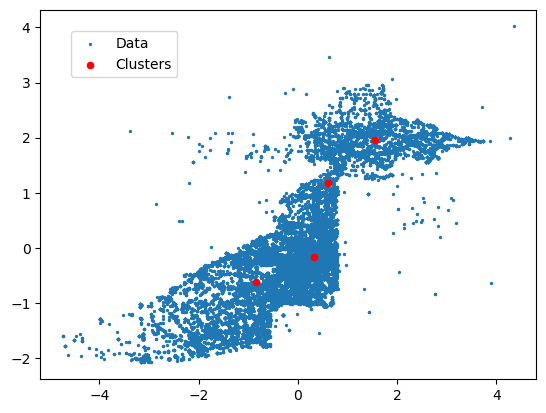

In [49]:
plt.scatter(MLEdata[:,0], MLEdata[:,1], s = 2)
plt.scatter(xmu,ymu, color = 'red', s = 20)
plt.figlegend(['Data', 'Clusters'], loc='upper right', bbox_to_anchor=(0.35, 0.85))
plt.show()

In [43]:
# loss = np.zeros(length)

# Q = np.zeros((nObs, nGroups))

# for y in range(nGroups):
#     vars()['mean'+str(y)] = np.random.normal(0, 1, size=2)
    
#     vars()['S'+str(y)] = np.random.normal(0, 1, size=(2, 2))
    
#     vars()['cov'+str(y)] = vars()['S'+str(y)] @ vars()['S'+str(y)].T + I

#     vars()['pi'+str(y)] = 1/nGroups

#     vars()['mu'+str(y)] = np.zeros(2)

#     vars()['count'+str(y)] = 0

# for y in range(nGroups):

#     vars()['p'+str(y)] = multivariate_normal.pdf(MLEdata, mean = vars()['mean'+str(y)], cov = vars()['cov'+str(y)])
    
# ##Start loop here

# for x in range(length):


#     for y in range(nGroups):

#         vars()['p'+str(y)] = vars()['p'+str(y)] * vars()['pi'+str(y)]


#     Ps = np.empty((nObs,nGroups))

#     for y in range(nGroups):

#         Ps[:,y] = vars()['p'+str(y)]

#     sumP = np.sum(Ps, axis = 1)

#     lossTemp = 0

#     for y in range(nGroups):


#         Q[:,y] = vars()['p'+str(y)] / sumP

#         vars()['s'+str(y)] = np.sum(Q[:,y])

#         vars()['mu'+str(y)] = np.dot(Q[:,y].T, MLEdata)/vars()['s'+str(y)]

#         vars()['diff'+str(y)] = MLEdata - vars()['mu'+str(y)]

#         vars()['cov'+str(y)] = vars()['diff'+str(y)].T.dot(vars()['diff'+str(y)]*Q[:,y][...,np.newaxis]) / vars()['s'+str(y)] + I

#         vars()['pi'+str(y)] = vars()['s'+str(y)] / nObs

#         vars()['p'+str(y)] = multivariate_normal.pdf(MLEdata, mean = vars()['mu'+str(y)], cov = vars()['cov'+str(y)])
        
#         lossTemp += np.sum(np.multiply(Q[:,y], np.log(vars()['pi'+str(y)]) + np.log(vars()['p'+str(y)]) ))
                
#     xmu = []
#     ymu = []
#     for i in range(nGroups):
#         xmu.append(vars()['mu'+str(i)][0])
#         ymu.append(vars()['mu'+str(i)][1])
        
#     plt.scatter(MLEdata[:,0], MLEdata[:,1])
#     plt.scatter(xmu,ymu, color = 'red')
#     plt.show()
    
    
#     loss[x] = lossTemp
    

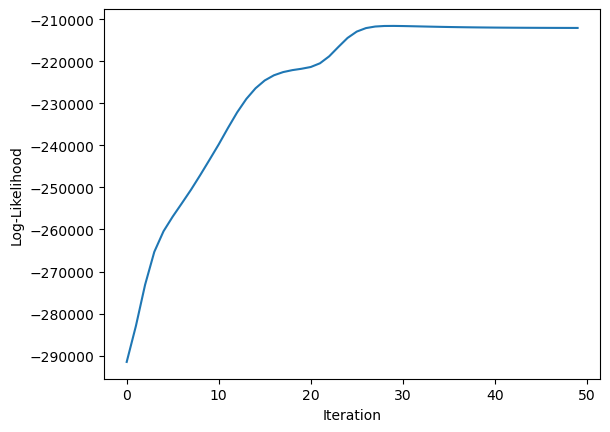

In [12]:
plt.plot(loss)
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.show()

## Visual of KDE with Cluster Centers

In [14]:
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

(-2.0, 3.0)

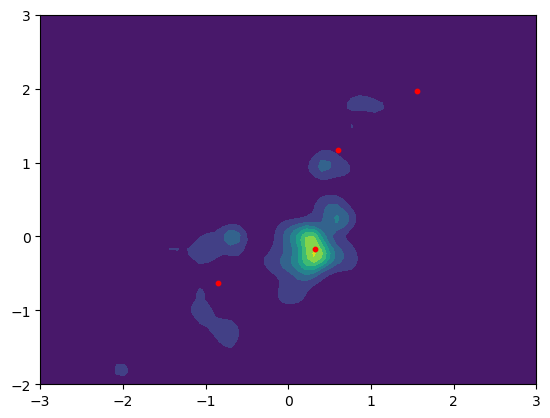

In [50]:
xx, yy, zz = kde2D(MLEdata[:,0], MLEdata[:,1], 0.107)
plt.contourf(xx, yy, zz)
plt.scatter(xmu,ymu, color = 'red', s = 10)
plt.xlim(-3,3)
plt.ylim(-2,3)

## Tune Number of Clusters

In [40]:
def sample(data, sizeL):
    choice = np.random.choice(range(data.shape[0]), size=(sizeL,), replace=False)
    ind = np.zeros(data.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    train = data[ind].copy()
    valid = data[rest].copy()
    return train,valid

In [41]:
#Without train/test split

maxK = 10

temp = []
nObs = len(MLEdata)
##Start Iters here
for z in range(1,maxK):

    for p in range(5):
        nGroups = z
        means, S, cov, pi, mu, count = initialize(nGroups)

        iters = 30

        I = np.eye(2)

        loss = np.zeros(maxK)
        loss_valid = np.zeros(maxK-1)

        p = update_P(MLEdata, means, cov)

        for x in range(iters):
            p = p*pi

            sumP = np.sum(p, axis = 1)

            Q = (p.T / sumP).T

            sums = np.sum(Q,axis = 0)

            mu = (np.dot(Q.T, MLEdata).T)/sums


            diff = np.zeros((nGroups,nObs,2))
            for y in range(nGroups):
                diff[y] = MLEdata - mu.T[y]
                cov[y] = diff[y].T.dot(diff[y]*Q[:,y][...,np.newaxis]) / sums[y] + 0.01*I  ###This addition to the covariance prevents any probabilities from being zero

            pi = sums / nObs

            p = update_P(MLEdata, mu.T, cov)

            lossTemp = 0
            for y in range(nGroups):
                lossTemp += np.sum(np.multiply(Q[:,y], np.log(pi[y]) + np.log(p[:,y]) ))

        
        loss[z-1] += lossTemp

    loss[z-1] /= 5
    temp.append(loss[z-1])
    

## BIC Optimization with Train/Test split

In [729]:
# maxK = 10

# temp = []

# ##Start Iters here
# for z in range(1,maxK):

#     for p in range(5):
#         train,valid = sample(MLEdata, 70000)
#         nGroups = z
#         means, S, cov, pi, mu, count = initialize(nGroups)

#         iters = 30
#         nObs = len(train[:,0])

#         I = np.eye(2)

#         loss = np.zeros(maxK)
#         loss_valid = np.zeros(maxK-1)

#         p = update_P(train, means, cov)

#         for x in range(iters):
#             p = p*pi

#             sumP = np.sum(p, axis = 1)

#             Q = (p.T / sumP).T

#             sums = np.sum(Q,axis = 0)

#             mu = (np.dot(Q.T, train).T)/sums


#             diff = np.zeros((nGroups,nObs,2))
#             for y in range(nGroups):
#                 diff[y] = train - mu.T[y]
#                 cov[y] = diff[y].T.dot(diff[y]*Q[:,y][...,np.newaxis]) / sums[y] + I ###This addition to the covariance prevents any probabilities from being zero

#             pi = sums / nObs

#             p = update_P(train, mu.T, cov)

#             lossTemp = 0
#             for y in range(nGroups):
#                 lossTemp += np.sum(np.multiply(Q[:,y], np.log(pi[y]) + np.log(p[:,y]) ))


#         ## Test error

#         p_valid = update_P(valid, mu.T, cov)*pi

#         sumP_valid = np.sum(p_valid, axis = 1)

#         Q_valid = (p_valid.T / sumP_valid).T

#         lossValid=0

#         for y in range(nGroups):
#             lossValid += np.sum(np.multiply(Q_valid[:,y], np.log(pi[y]) + np.log(p_valid[:,y]) ))

        
#         loss_valid[z-1] += lossValid

#     loss_valid[z-1] /= 5
#     temp.append(loss_valid[z-1])

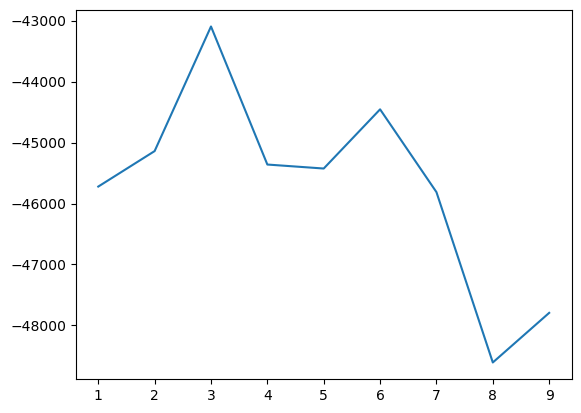

In [42]:
plt.plot(range(1,maxK), temp)


In [43]:
##Temp is the list of CV losses

In [44]:
20*np.log(90000)

228.15129898624804

In [45]:
BIC = []
for x,i in enumerate(temp):
    calc = (x+1)*np.log(90000) - 2*i
    BIC.append(calc)
    

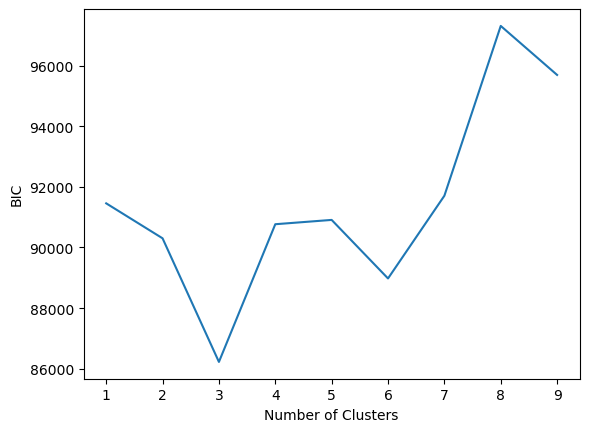

In [46]:
plt.plot(range(1,maxK), BIC)
plt.xlabel("Number of Clusters")
plt.ylabel("BIC")
plt.show()

## Add probabilities back to original dataframe

In [47]:
##Confirm order is same for original dataframe and probabilities
MLEdata == filtered[['lat', 'lng']]


,lat,lng
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
94888,True,True
94889,True,True
94890,True,True
94891,True,True


In [75]:
renameDictionary = {}
for i in range(nGroups):
    renameDictionary[i] = 'Cluster'+str(i+1)
    

pDF = pd.DataFrame(p > 0.6).rename(columns = renameDictionary).astype('int')

In [76]:
# closestCluster = np.array(pd.DataFrame(np.argmax(p, axis = 1)).replace(renameDictionary))
closestCluster = np.argmax(p, axis = 1)+1

In [77]:
filtered = filtered.reset_index(drop = True)

In [68]:
addedCluster = pd.concat([filtered, pDF], axis = 1)
addedCluster['ClosestCluster'] = closestCluster

In [61]:
addedCluster.to_csv('dataWithAssignment.csv')

In [62]:
pd.DataFrame(mu.T, columns = ['x','y']).to_csv('clusterMeans.csv')